In [114]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [115]:
import numpy as np
import pandas as pd
from pandas import DataFrame

In [116]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [117]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [118]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [119]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [120]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [121]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [122]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [123]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_date = last_data_point[0]

last_date_dt = dt.datetime.strptime(last_date,'%Y-%m-%d')
print('Last date in precipitation measurements: ' + last_date)

year_before_dt = dt.date(last_date_dt.year-1,last_date_dt.month,last_date_dt.day)
year_before = dt.datetime.strftime(year_before_dt,'%Y-%m-%d')
print('A year before last precipitation measurements: ' + year_before)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_before)

df = DataFrame(results)

df.set_index('date',inplace = True)
df.sort_index(inplace=True)

df.head()

Last date in precipitation measurements: 2017-08-23
A year before last precipitation measurements: 2016-08-23


,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


<Figure size 864x576 with 0 Axes>

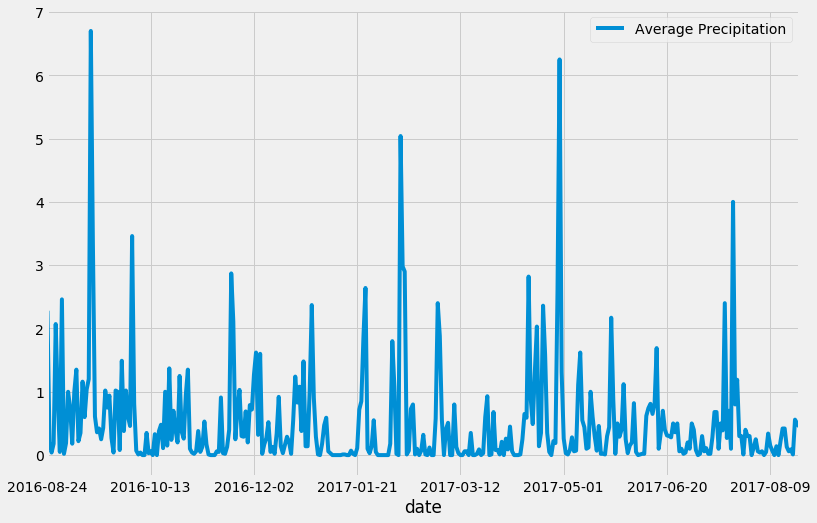

In [124]:
# It is not clear in the instructions, but it seems that the plot should be on maximum precipitation by date

results_avg = session.query(
    Measurement.date,
    func.max(Measurement.prcp).label('Average Precipitation')) \
.group_by(Measurement.date) \
.filter(Measurement.date > year_before) \
.order_by(Measurement.date).all()

df_avg = DataFrame(results_avg)
df_avg.head()

df_avg.set_index('date',inplace = True)
df_avg.sort_index(inplace=True)

fig = plt.figure(figsize=(12,8))
df_avg.plot(figsize=(12,8))

In [125]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [126]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct(Measurement.station).count()
print ('Total Stations: '+ str(station_count))

Total Stations: 9


In [127]:
stations = session.query(Station.id,Station.name,Station.latitude,Station.longitude,Station.elevation)
df = DataFrame(stations)
df.head(10)

,id,name,latitude,longitude,elevation
0,1,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [128]:
# What are the most active stations? (i.e. what stations have the most rows (I am assuming precipitation measures))?
# List the stations and the counts in descending order.

results_stations = session.query(
    Measurement.station,
    func.count(Measurement.prcp).label('Count')) \
.group_by(Measurement.station) \
.order_by(func.count(Measurement.prcp).desc()).all()

df_stations = DataFrame(results_stations)
df_stations.head(10)

,station,Count
0,USC00519281,2772
1,USC00513117,2696
2,USC00519397,2685
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


In [129]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?

Station_ID = df_stations['station'].iloc[0]
print ("Station ID: " + Station_ID)

Station ID: USC00519281


In [130]:
results = session.query(
    Measurement.station,
    func.min(Measurement.tobs).label('Lowest Temperature'),
    func.max(Measurement.tobs).label('Highest Temperature'),
    func.avg(Measurement.tobs).label('Average Temperature')
).filter(Measurement.station == Station_ID)

df_station_summary = DataFrame(results)
df_station_summary.head(1)

,station,Lowest Temperature,Highest Temperature,Average Temperature
0,USC00519281,54.0,85.0,71.663781


In [131]:
# Choose the station with the highest number of temperature observations.
# Repeat calculation as it could be a different station
 
results = session.query(
    Measurement.station,
    func.count(Measurement.tobs).label('Count'))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.tobs).desc()).all()

df_station_summary = DataFrame(results)

Station_ID = df_station_summary['station'].iloc[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == Station_ID).filter(Measurement.date >  year_before )

df = DataFrame(results)
df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


Text(0, 0.5, 'Frequency')

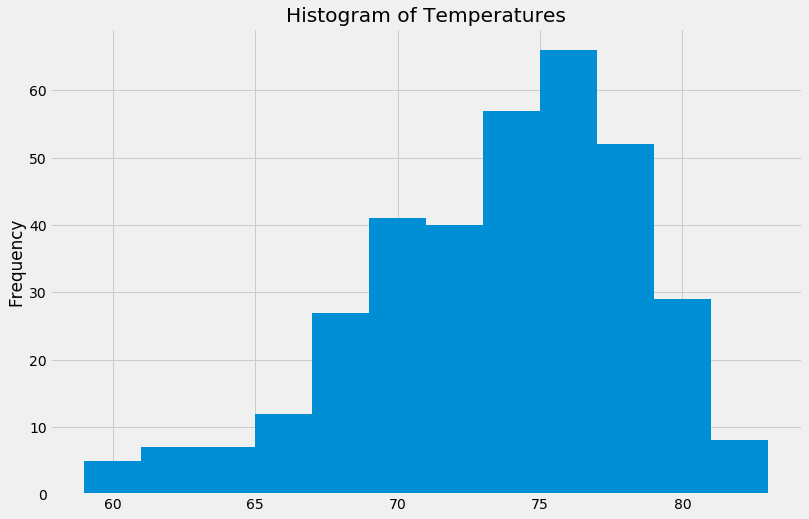

In [132]:
# Use Pandas Plotting with Matplotlib to plot the data

df_last_year = DataFrame(results)

df_last_year.set_index('date')
df_last_year.sort_index(inplace=True)

#fig = plt.figure(figsize=(12,8))
#plt.hist(df["date"], df["tobs"], align='center', alpha=.75) 


df_last_year.hist(column='tobs', bins=12, grid=True, figsize=(12,8))

plt.title('Histogram of Temperatures')
plt.ylabel('Frequency')


In [133]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Select a range of dates in the future

From_Dt_Input= '2020-02-01'
To_Dt_Input= '2020-02-15'

From_Dt = df_last_year.loc[df_last_year['date'].str.contains(From_Dt_Input[5:10])].iloc[0,0]
To_Dt = df_last_year.loc[df_last_year['date'].str.contains(To_Dt_Input[5:10])].iloc[0,0]

print ('Vacation Start Dt: ' + From_Dt_Input)
print ('Vacation End Dt: ' + To_Dt_Input )
print ('Last Year Start Dt: ' + From_Dt)
print ('Last Year End Dt: ' + To_Dt)

results = session.query(
    Measurement.station,
    func.sum(Measurement.prcp).label('Total Precipitation'),
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation).filter(Measurement.station == Station.station) \
.filter(Measurement.date >= From_Dt).filter(Measurement.date <=  To_Dt) \
.group_by(Measurement.station) \
.order_by(func.sum(Measurement.prcp).desc()).all()

df = DataFrame(results)
df.head(10)

Vacation Start Dt: 2020-02-01
Vacation End Dt: 2020-02-15
Last Year Start Dt: 2017-02-01
Last Year End Dt: 2017-02-15


,station,Total Precipitation,name,latitude,longitude,elevation
0,USC00513117,7.31,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,USC00519523,6.91,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
2,USC00519281,6.23,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00514830,5.24,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00516128,4.43,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
5,USC00519397,3.45,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## First Additional Question - Temperature Analysis I

In [134]:
from scipy.stats import ttest_ind

results = session.query(
    func.avg(Measurement.tobs).label('Average')
).filter(Measurement.date.like("%-06-%")).all()

June_Average = results[0][0]
         
results = session.query(
    func.avg(Measurement.tobs).label('Average'))\
.filter(Measurement.date.like("%-12-%")).all()

December_Average =  results[0][0]

print ("June Temperature Average: " + str(June_Average))
print ("December Temperature Average: " + str(December_Average))

# Calculate the T-Test is different 

results = session.query(
    Measurement.tobs).filter(Measurement.date.like("%-06-%")).all()
June_Results = DataFrame(results)

results = session.query(
    Measurement.tobs).filter(Measurement.date.like("%-12-%")).all()
December_Results = DataFrame(results)

t, p = ttest_ind(June_Results, December_Results, equal_var=True)

print ('t-value: ' + str(t))
print ('p-value: ' + str(p))

June Temperature Average: 74.94411764705882
December Temperature Average: 71.04152933421226
t-value: [31.60372399]
p-value: [3.9025129e-191]


The t-test results indicate that there are significant differences between the June temperatures and the December temperatures. 

## Second Additional Question - Temperature Analysis II

In [135]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


Last Year Temperatures
Lowest Temperature: 58.00
Average Temperature: 74.59
Highest Temperature: 87.00

Next Vacation Temperatures From 2017-02-01 to 2017-02-15
Lowest Temperature: 59.00
Average Temperature: 69.72
Highest Temperature: 80.00


Text(0, 0.5, 'Temperatures (F)')

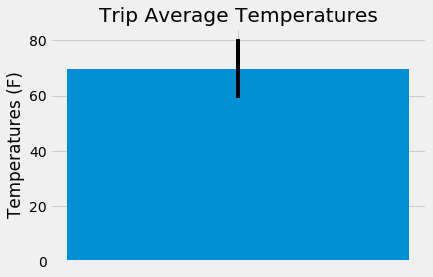

In [136]:
# Use the previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for the last year of data

tmin,tave,tmax = calc_temps(year_before, last_date)[0]
print ('Last Year Temperatures')
print ('Lowest Temperature: ' + '%.2f' % tmin)
print ('Average Temperature: ' + '%.2f' % tave)
print ('Highest Temperature: ' + '%.2f' % tmax)

# Use the previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Select a range of dates in the future (These are the vacation dates From_Dt_Input and To_Dt_Input defined before)

# Repeat the calculation for the same dates using last year's data

From_Dt = df_last_year.loc[df_last_year['date'].str.contains(From_Dt_Input[5:10])].iloc[0,0]
To_Dt = df_last_year.loc[df_last_year['date'].str.contains(To_Dt_Input[5:10])].iloc[0,0]


tmin,tave,tmax = calc_temps(From_Dt, To_Dt)[0]
print ('\nNext Vacation Temperatures From ' + From_Dt + ' to ' + To_Dt)
print ('Lowest Temperature: ' + '%.2f' % tmin)
print ('Average Temperature: ' + '%.2f' % tave)
print ('Highest Temperature: ' + '%.2f' % tmax)

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr) - Should it be half of that?
plt.bar('', tave, yerr=[[tave-tmin,tmax-tave]])
plt.title('Trip Average Temperatures')
plt.ylabel('Temperatures (F)')

## Third Additional Question - Daily Rainfall Average

In [137]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()


In [138]:
# calculate the daily normals for your trip

# Set the start and end date of the trip

print ('Vacation Start Dt: ' + From_Dt_Input)
print ('Vacation End Dt: ' + To_Dt_Input )

From_Dt= dt.datetime.strptime(From_Dt_Input,'%Y-%m-%d')
To_Dt= dt.datetime.strptime(To_Dt_Input,'%Y-%m-%d')


total_days = To_Dt - From_Dt

# Create the dataframe to hold the data
df = pd.DataFrame(columns = ["Date","T Min","T Average","T Max"])

for i in range(total_days.days+1): 
    idate = From_Dt + dt.timedelta(days=i)
    tmin,tave,tmax = daily_normals(func.strftime("%m-%d",idate))[0]
    df.loc[i]= [idate, tmin, tave, tmax]
    
df.head(20)

Vacation Start Dt: 2020-02-01
Vacation End Dt: 2020-02-15


,Date,T Min,T Average,T Max
0,2020-02-01,56.0,68.140351,78.0
1,2020-02-02,59.0,68.859649,77.0
2,2020-02-03,58.0,67.796610,77.0
3,2020-02-04,61.0,68.140351,76.0
4,2020-02-05,59.0,69.684211,80.0
5,2020-02-06,58.0,70.389831,77.0
6,2020-02-07,60.0,69.000000,77.0
7,2020-02-08,56.0,66.754386,74.0
8,2020-02-09,57.0,67.589286,75.0
9,2020-02-10,56.0,68.416667,76.0


In [139]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df.set_index('Date',inplace = True)
df.sort_index(inplace=True)
df.head()

,T Min,T Average,T Max
Date,,,
2020-02-01,56.0,68.140351,78.0
2020-02-02,59.0,68.859649,77.0
2020-02-03,58.0,67.796610,77.0
2020-02-04,61.0,68.140351,76.0
2020-02-05,59.0,69.684211,80.0


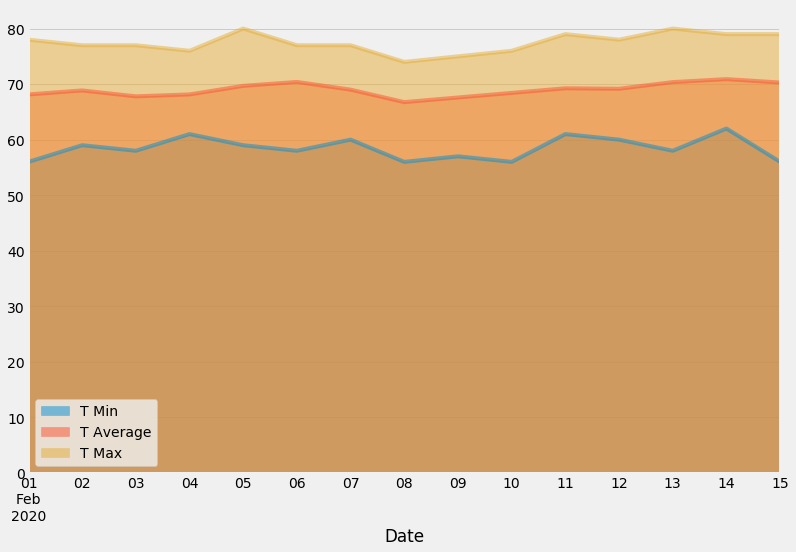

In [140]:
# Plot the daily normals as an area plot with `stacked=False`
>>> ax = df.plot.area(stacked=False,figsize=(12,8))